## Skin Cancer Detection using Machine Learning


## Loading Libraries


In [20]:
# <==== Importing Neccesary libraries ===>
import os
import numpy as np
from numpy import loadtxt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from PIL import Image
import random
from random import shuffle
import cv2
from tqdm import tqdm
from PIL import Image
from random import shuffle
from itertools import cycle

# <==== Tensorflow & Machine Learning lib ===>
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model, layers
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

# <==== Performance Metrics ===>
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

In [21]:
# setting path of directory
B_DIR = "ISIC_2019_ML/Bcc"
M_DIR =  "ISIC_2019_ML/Melanoma"
N_DIR = "ISIC_2019_ML/Navus"
I_dir = "ISIC_2019_ML"
I_Var = "ISIC_2019_ML/isic_vars"

In [25]:
# loading the saved variables
#I_Var = "ISIC_2019_ML/isic_vars"
x_train = np.load(I_Var+"/x_train.npy")
y_train = np.load(I_Var+"/y_train.npy")
x_test = np.load(I_Var+"/x_test.npy")
y_test = np.load(I_Var+"/y_test.npy")
num_classes = np.load(I_Var+"/num_classes.npy")
len_data = np.load(I_Var+"/len_data.npy")
train_len = np.load(I_Var+"/train_len.npy")
test_len = np.load(I_Var+"/test_len.npy")

FileNotFoundError: [Errno 2] No such file or directory: 'ISIC_2019_ML/isic_vars/x_train.npy'

## Model Building


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output and add dense layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 86528)             0

reference: https://keras.io/api/callbacks/


In [ ]:
# Set up callbacks
# Stop training when a val_loss has stopped improving for a specified patience = 3.
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# ModelCheckpoint: Save the model after every epoch if the val_loss has improved.
model_checkpoint = ModelCheckpoint('skin_cancer_model.h5', save_best_only=True)

# Reduce learning rate when a metric val_loss has stopped improving.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)
# min_lr: lower bound on the learning rate.

# Train the model
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping, model_checkpoint, reduce_lr])

Epoch 1/20
243/243 [==============================] - 409s 2s/step - loss: 0.9529 - accuracy: 0.5465 - val_loss: 1.1125 - val_accuracy: 0.5232
Epoch 2/20
243/243 [==============================] - 386s 2s/step - loss: 0.8370 - accuracy: 0.6155 - val_loss: 0.8946 - val_accuracy: 0.5803
Epoch 3/20
243/243 [==============================] - 387s 2s/step - loss: 0.7865 - accuracy: 0.6455 - val_loss: 0.8117 - val_accuracy: 0.6406
Epoch 4/20
243/243 [==============================] - 385s 2s/step - loss: 0.7293 - accuracy: 0.6740 - val_loss: 0.7497 - val_accuracy: 0.6581
Epoch 5/20
243/243 [==============================] - 385s 2s/step - loss: 0.6816 - accuracy: 0.6982 - val_loss: 0.7301 - val_accuracy: 0.6658
Epoch 6/20
243/243 [==============================] - 389s 2s/step - loss: 0.6180 - accuracy: 0.7327 - val_loss: 0.7494 - val_accuracy: 0.6684
Epoch 7/20
243/243 [==============================] - 386s 2s/step - loss: 0.5487 - accuracy: 0.7663 - val_loss: 0.7680 - val_accuracy: 0.6807

In [ ]:
# Save the trained model
# model = load_model('skin_cancer_model.h5')
model.save('skin_cancer_model.h5')

In [ ]:
# Load model
model = load_model('skin_cancer_model.h5')

## Model Evaluation


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

76/76 [==============================] - 66s 785ms/step - loss: 0.7223 - accuracy: 0.7108
Test Loss: 0.7223, Test Accuracy: 0.7108


In [ ]:
# Make predictions using the loaded model
y_pred = model.predict(x_test)

# Convert the one-hot encoded labels back to integer labels
y_true = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

reference: https://onestopdataanalysis.com/confusion-matrix-python/


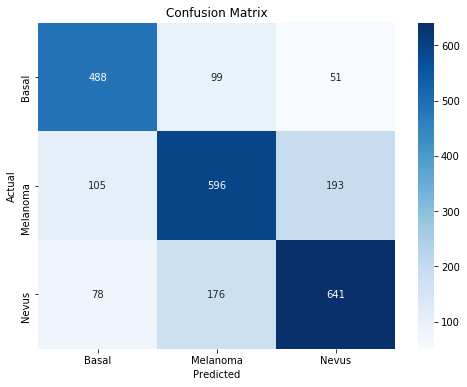

Classification Report:
             precision    recall  f1-score   support

          0       0.73      0.76      0.75       638
          1       0.68      0.67      0.68       894
          2       0.72      0.72      0.72       895

avg / total       0.71      0.71      0.71      2427



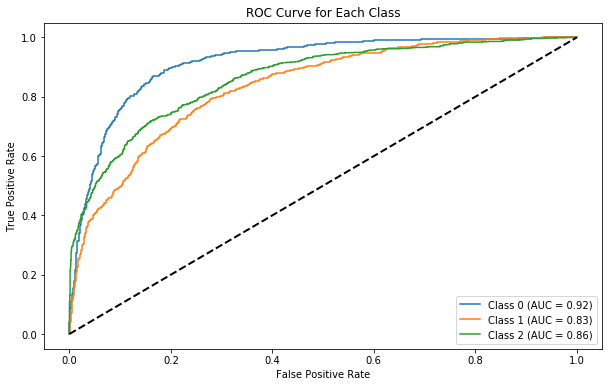

Weighted Precision: 0.7103
Weighted Recall: 0.7108
Weighted F1 Score: 0.7104


In [ ]:
# import seaborn as sns
# from sklearn.metrics import precision_score, recall_score, f1_score
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Basal', 'Melanoma', 'Nevus'], yticklabels=['Basal', 'Melanoma', 'Nevus'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(y_true, y_pred_classes)
print("Classification Report:")
print(class_report)

# Compute ROC curves for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC Curve
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()

# Precision, Recall, F1 Score
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f'Weighted Precision: {precision:.4f}')
print(f'Weighted Recall: {recall:.4f}')
print(f'Weighted F1 Score: {f1:.4f}')


## Model Evaluation on Testing Data


In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

# Set the path to the new dataset directory
F_DIR = "ISIC_2019_ML/Test_Data_3"

In [2]:
#Testing -  Load model
model = load_model('skin_cancer_model.h5')

NameError: name 'load_model' is not defined

In [ ]:
# Read and preprocess the new dataset
new_data = []
True_labels = []

# Iterate through the files
for filename in os.listdir(F_DIR):
    try:
        image_path = os.path.join(F_DIR, filename)
        image = cv2.imread(image_path)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        new_data.append(np.array(size_image))
        # Extract labels
        if filename[0] == 'b':
            True_labels.append(0)
        elif filename[0] == 'm':
            True_labels.append(1)
        elif filename[0] == 'n':
            True_labels.append(2)

    except Exception as e:
        print(f"Error processing {filename}: {str(e)}")

In [ ]:
# Convert the list to a numpy array
new_data = np.array(new_data)

# Normalize the new dataset
new_data = new_data.astype('float32') / 255

In [ ]:
# Make predictions on the new dataset
new_predictions = model.predict(new_data)

In [ ]:
# Convert the predictions to class labels
predicted_labels = np.argmax(new_predictions, axis=1)

In [ ]:
# Print the predicted labels or perform further analysis as needed
print("Predicted Labels:", predicted_labels)

Predicted Labels: [0 0 0 1 2 0 0 0 0 1 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2
 0 1 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 2 1 1 1 1 1 2 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 2 1 1 2 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 0 1 2 1 1 1 2
 1 1 1 1 1 2 0 1 1 1 1 1 2 1 1 1 1 1 2 1 2 1 1 1 2 1 0 1 1 1 1 1 2 1 2 2 1
 1 1 1 1 1 0 1 2 1 1 1 1 1 1 0 2 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 0 1 0 1 1 1 0 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 0 1
 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 0 1 1 1 1 2 1 2
 1 1 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 1 2 2 2 2 1 2 2 2 2 2 2 2
 2 2 2 

In [ ]:
true_labels_CN1 = True_labels

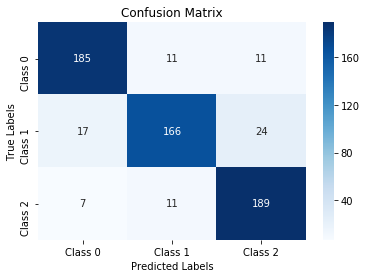

In [ ]:
# Create the confusion matrix
conf_matrix = confusion_matrix(true_labels_CN1, predicted_labels)

# Plot the confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'],
            yticklabels=['Class 0', 'Class 1', 'Class 2'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

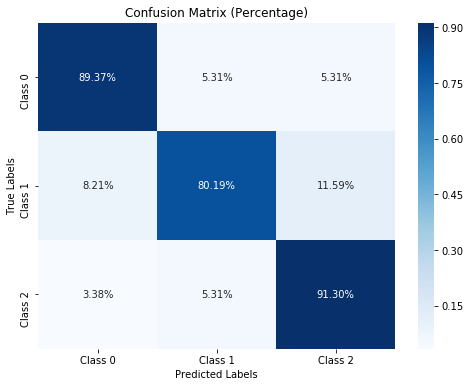

In [ ]:
# Create the confusion matrix
conf_matrix = confusion_matrix(true_labels_CN1, predicted_labels)

# Convert to percentages
conf_matrix_percentage = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Create a heatmap with annotations and percentage format
sns.heatmap(conf_matrix_percentage, annot=True, fmt=".2%", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])

plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.show()

In [ ]:
# Classification Report
class_names = ["Class 0", "Class 1", "Class 2"]
report = classification_report(true_labels_CN1, predicted_labels, target_names=class_names)

print("Classification Report:")
print(report)

Classification Report:
             precision    recall  f1-score   support

    Class 0       0.89      0.89      0.89       207
    Class 1       0.88      0.80      0.84       207
    Class 2       0.84      0.91      0.88       207

avg / total       0.87      0.87      0.87       621



In [ ]:
# Calculate the overall accuracy
overall_accuracy = accuracy_score(true_labels_CN1, predicted_labels)

# Print the overall accuracy
print(f'Overall Accuracy: {overall_accuracy:.4f}')

Overall Accuracy: 0.8696
